In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import sys
import math
import xlsxwriter

plt.ion()   # interactive mode

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation

TRAIN = 'train'
VAL = 'val'

data_transforms = {
    TRAIN: transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    VAL: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'C:/Users/Spooky/Documents/Project'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in [TRAIN, VAL]}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in [TRAIN, VAL]}
dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, VAL]}
class_names = image_datasets[TRAIN].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")
else:
    print(use_gpu)
print(device)
    

Using CUDA
cuda:0


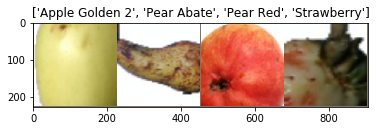

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders[TRAIN]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    
    fileName = "out.xlsx"
    workbook = xlsxwriter.Workbook(fileName)
    worksheet = workbook.add_worksheet()
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in [TRAIN, VAL]:
            if phase == TRAIN:
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == TRAIN):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == TRAIN:
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == TRAIN:
                worksheet.write(epoch, 0, epoch_loss)
                worksheet.write(epoch, 1, epoch_acc)
            else:
                worksheet.write(epoch, 2, epoch_loss)
                worksheet.write(epoch, 3, epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == VAL and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    workbook.close()

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders[VAL]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [7]:
## -- Resnet

#model_ft = models.resnet18(pretrained=True)
#num_ftrs = model_ft.fc.in_features
#model_ft.fc = nn.Linear(num_ftrs, 10)

#model_ft = model_ft.to(device)


## -- Alex Net
model_ft = models.alexnet(pretrained=True)
num_features = model_ft.classifier[6].in_features
features = list(model_ft.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, len(class_names))]) # Add our layer with 4 outputs
model_ft.classifier = nn.Sequential(*features) # Replace the model classifier

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0001, momentum=0.1)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

print(model_ft)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p

In [10]:
resume_training = True

if resume_training:
    print("Loading pretrained model..")
    model_ft.load_state_dict(torch.load('C:/Users/Spooky/Documents/Project/alexnet_trained_model_101_01.pt'))
    print("Loaded!")

Loading pretrained model..
Loaded!


In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=60)

Epoch 0/59
----------
train_f Loss: 3.0569 Acc: 0.1967
val_f Loss: 2.4322 Acc: 0.3686

Epoch 1/59
----------
train_f Loss: 2.0699 Acc: 0.4604
val_f Loss: 1.6078 Acc: 0.5975

Epoch 2/59
----------
train_f Loss: 1.4355 Acc: 0.6056
val_f Loss: 1.1113 Acc: 0.6992

Epoch 3/59
----------
train_f Loss: 1.1374 Acc: 0.6900
val_f Loss: 0.8704 Acc: 0.7542

Epoch 4/59
----------
train_f Loss: 0.9350 Acc: 0.7281
val_f Loss: 0.7407 Acc: 0.7839

Epoch 5/59
----------
train_f Loss: 0.8496 Acc: 0.7384
val_f Loss: 0.6861 Acc: 0.7966

Epoch 6/59
----------
train_f Loss: 0.7004 Acc: 0.7909
val_f Loss: 0.6030 Acc: 0.8263

Epoch 7/59
----------
train_f Loss: 0.6094 Acc: 0.8187
val_f Loss: 0.5898 Acc: 0.8263

Epoch 8/59
----------
train_f Loss: 0.6396 Acc: 0.8146
val_f Loss: 0.5880 Acc: 0.8220

Epoch 9/59
----------
train_f Loss: 0.6664 Acc: 0.7961
val_f Loss: 0.5793 Acc: 0.8220

Epoch 10/59
----------
train_f Loss: 0.6297 Acc: 0.8177
val_f Loss: 0.5797 Acc: 0.8136

Epoch 11/59
----------
train_f Loss: 0.633

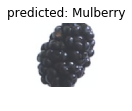

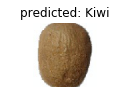

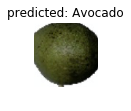

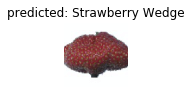

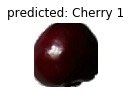

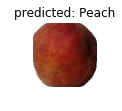

In [12]:
visualize_model(model_ft)


In [10]:
torch.save(model_ft.state_dict(), 'alexnet_trained_model_f_05.pt')